# Hindcast verification
This Notebook evaluates the performance of ensemble seasonal flow hindcasts. This is done using deterministic and probabilistic verification metrics that capture various attributes of the forecasts (e.g., accuracy, skill, reliability, etc.). To get a complete understanding of the quality of a forecast, several different verification metrics can be calculated that aim to capture 1 or multiple of these attributes. For more info see this [forecast verification documentation](https://www.cawcr.gov.au/projects/verification/).

Throughout this Notebook, target period refers to the period of time that is being forecast (e.g., flow accumulation between January and September) and start date/initialization date refers to the time when the forecast was issued (e.g., 1st of January).

Decisions:
- We use the ensemble hindcast medians to calculate deterministic metrics.
- The observations climatology is used as baseline for skill calculations.
- For the ROC, we calculate results for low flows (<= perc_event_low_default) & high flows (>= perc_event_high_default). Both thresholds are defined in user-specified variables but the signs are hardcoded in the function "prob_metrics_calculation".
- We calculate ROC for 2 events only at a time.
- We calculate ROC using 0.1 bins (i.e., 0-0.1, 0.1-0.2, ..., 0.9-1).

# Modules, paths, variables & functions
Paths & variables are the only elements you should need to modify.

In [2]:
# Import required modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy import stats
from sklearn import metrics
import properscoring as ps
import xarray as xr
import datetime
import seaborn as sns

In [41]:
# Set user-specified variables
testbasin_id = '05BB001'  # test basin ID taken from WSC HYDAT
testbasin_name = 'Bow River at Banff'  # test basin name taken from WSC HYDAT
niterations_default = 100 # number of iterations for bootstrapping
perc_event_low_default, perc_event_high_default = .33, .66  # low and high flow percentiles to use for the ROC calculations

In [155]:
# Function to calculate the correlation coefficient
def corr_coeff_squared(Qobs, Qfc_det):
    
    """Calculates the squared correlation coefficient between deterministic forecasts & observations.
    Answers the question: How well did the forecast values correspond to the observed values?
    Range: -1 to 1. Perfect score: 1. Units: Unitless.
    Characteristics: Good measure of linear association - visually, the correlation measures how close the points of a scatter plot are to a straight line. Does not take forecast bias into account. Sensitive to outliers.
    
    Keyword arguments:
    ------------------ 
    - Qobs: xarray DataArray containing a timeseries of observed flow values.
    - Qfc_det: xarray DataArray containing a timeseries of deterministic flow forecasts (e.g., medians or means of the ensemble forecasts).
    
    Returns:
    --------
    - r_squared: Float of the squared correlation coefficient between the deterministic forecasts & observations.
    
    """

    r_squared = stats.pearsonr(Qobs.values, Qfc_det.values)[0] ** 2
    
    return r_squared

In [156]:
def KGE_C2021(Qobs, Qfc_det): 
    
    """Calculates the modified Kling-Gupta Efficiency (KGE") and its 3 components.
    The KGE measures the correlation, bias and variability of the simulated values against the observed values.
    KGE" was proposed by Clark et al. (2021) to solve issues arising with 0 values in the KGE or KGE'.
    For more info, see Clark et al. (2021): https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2020WR029001
    KGE" range: -Inf to 1. Perfect score: 1. Units: Unitless.
    Correlation (r): Perfect score is 1.
    Bias (beta): Perfect score is 1.
    Variability (alpha):  Perfect score is 1.
    
    Keyword arguments:
    ------------------ 
    - Qobs: Numpy array containing a timeseries of observed flow values.
    - Qfc_det: Numpy array containing a timeseries of deterministic flow forecasts (e.g., medians or means of the ensemble forecasts).
    
    Returns:
    --------
    - KGEgroup: Dictionary of the KGE" and its 3 components.
    
    """
    
    ind_nan = np.isnan(Qobs) | np.isnan(Qfc_det)
    Obs = Qobs[~ind_nan]
    Pre = Qfc_det[~ind_nan]
    if len(Obs)>3:
        pre_mean = np.mean(Pre, axis=0, dtype=np.float64)
        obs_mean = np.mean(Obs, axis=0, dtype=np.float64)
        r = np.sum((Pre - pre_mean) * (Obs - obs_mean), axis=0, dtype=np.float64) / \
            np.sqrt(np.sum((Pre - pre_mean) ** 2, axis=0, dtype=np.float64) *
                    np.sum((Obs - obs_mean) ** 2, dtype=np.float64))
        alpha = np.std(Pre, axis=0) / np.std(Obs, dtype=np.float64)
        beta = (np.mean(Pre) - np.mean(Obs)) / np.std(Obs)
        KGE = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta) ** 2)
        KGEgroup = {'KGE': KGE, 'r': r, 'alpha': alpha, 'beta': beta}
    else:
        KGEgroup = {'KGE': np.nan, 'r': np.nan,
                    'alpha': np.nan, 'beta': np.nan}
        
    return KGEgroup

In [157]:
def det_metrics_calculation(Qobs, Qfc_det, flag, niterations):
    
    """Calculates deterministic metrics for whole hindcast timeseries (1 value per hindcast start date & target period).
    
    Keyword arguments:
    ------------------ 
    - Qobs: xarray Dataset containing timeseries of observed flow values for various target periods of flow accumulation.
    - Qfc_det: xarray Dataset containing timeseries of deterministic flow forecasts for various target periods and forecast start dates.
    - flag: Integer to indicate whether the metrics should be calculated without (0) or with (1) bootstrapping
    - niterations: Integer > 0 of the number of bootstrapping iterations to perform
    
    Returns:
    --------
    - rsquared_da: xarray DataArray of squared correlation coefficient values for various forecast start dates & target periods
    - kge_da: xarray DataArray of KGE" values for various forecast start dates & target periods
    
    """
    
    # Read the start dates & target periods we will be calculating metrics for
    initmonths = Qfc_det.init_month.values
    targetperiods = list(Qfc_det.keys())

    # Initialize the verification metrics' arrays depending on whether bootstrapping is performed
    if flag == 0:
        rsquared_array = np.ones((len(targetperiods),len(initmonths))) * np.nan
        kge_array = np.ones((len(targetperiods),len(initmonths))) * np.nan
    elif flag == 1:
        rsquared_array = np.ones((len(targetperiods),len(initmonths),niterations)) * np.nan
        kge_array = np.ones((len(targetperiods),len(initmonths),niterations)) * np.nan

    # Initialize the row counter to save results in the right place
    row = -1

    # Loop over forecast starting dates
    for i in initmonths:
        
        # increment/initialize the row/column counters to save results in the right place
        row += 1
        column = -1

        # loop over target periods
        for t in targetperiods:

            # increment the column counter to save results in the right place
            column += 1

            # read forecasts & observations
            Qfc_det_data = Qfc_det[t].sel(init_month=i).dropna(dim='year')
            Qobs_data = Qobs[t].sel(year=Qfc_det_data.year)
            
            # if there are no forecasts we skip this start date-target period
            if np.isnan(Qfc_det_data.values).all() == True:
                continue
            
            # else, we can proceed with the verification metrics calculations
            else:

                if flag == 0:
                    # R2 
                    rsquared_array[column,row] = round(corr_coeff_squared(Qobs_data, Qfc_det_data),2)
                    # KGE"
                    kge_array[column,row] = round(KGE_C2021(Qobs_data.values, Qfc_det_data.values)['KGE'],2)
                    
                elif flag == 1:
                    
                    for b in range(niterations):
                        
                        # random samples for bootstrapping with replacement
                        samples = np.random.choice(len(Qobs_data), len(Qobs_data))
                        Qfc_det_data_bs = Qfc_det_data.isel(year=samples)
                        Qobs_data_bs = Qobs_data.isel(year=samples)
                        
                        # R2 
                        rsquared_array[column,row,b] = round(corr_coeff_squared(Qobs_data_bs, Qfc_det_data_bs),2)
                        # KGE"
                        kge_array[column,row,b] = round(KGE_C2021(Qobs_data_bs.values, Qfc_det_data_bs.values)['KGE'],2)

    # Save values to xarray DataArrays
    if flag == 0:
        # R2 
        rsquared_da = xr.DataArray(data=rsquared_array, coords={'init_month':initmonths,'target_period':[x[4::] for x in targetperiods]}, dims=['init_month','target_period'], name='R2')
        # KGE"
        kge_da = xr.DataArray(data=kge_array, coords={'init_month':initmonths,'target_period':[x[4::] for x in targetperiods]}, dims=['init_month','target_period'], name='KGE"')
        
    elif flag == 1:
        # R2 
        rsquared_da = xr.DataArray(data=rsquared_array, coords={'init_month':initmonths,'target_period':[x[4::] for x in targetperiods],'iteration':np.arange(1,niterations+1)}, dims=['init_month','target_period','iteration'], name='R2')
        rsquared_da.iteration.attrs['long_name'] = 'Bootstrapping iterations'
        rsquared_da.iteration.attrs['info'] = 'We pick random samples of the datasets for bootstrapping with replacement in order to capture uncertainties in the verification metric estimates.'
        # KGE"
        kge_da = xr.DataArray(data=kge_array, coords={'init_month':initmonths,'target_period':[x[4::] for x in targetperiods],'iteration':np.arange(1,niterations+1)}, dims=['init_month','target_period','iteration'], name='KGE"')
        kge_da.iteration.attrs['long_name'] = 'Bootstrapping iterations'
        kge_da.iteration.attrs['info'] = 'We pick random samples of the datasets for bootstrapping with replacement in order to capture uncertainties in the verification metric estimates.'
    
    # R2 
    rsquared_da.init_month.attrs['long_name'] = 'Hindcast starting dates'
    rsquared_da.init_month.attrs['info'] = 'Months when the hindcasts where produced. Note that hindcasts were produced on the 1st day of these month.'
    rsquared_da.target_period.attrs['long_name'] = 'Hindcast target periods'
    rsquared_da.target_period.attrs['info'] = 'Time period for which flow volumes are being forecasted.'
    rsquared_da.attrs['long_name'] = 'Squared correlation coefficient'
    rsquared_da.attrs['info'] = 'Measures the linear association between deterministic hindcasts (medians) & observations. Range: -1 to 1. Perfect score: 1. Units: Unitless.'
    # KGE"
    kge_da.init_month.attrs['long_name'] = 'Hindcast starting dates'
    kge_da.init_month.attrs['info'] = 'Months when the hindcasts where produced. Note that hindcasts were produced on the 1st day of these month.'
    kge_da.target_period.attrs['long_name'] = 'Hindcast target periods'
    kge_da.target_period.attrs['info'] = 'Time period for which flow volumes are being forecasted.'
    kge_da.attrs['long_name'] = 'Modified Kling Gupta Efficiency'
    kge_da.attrs['info'] = 'Measures the correlation, bias & variability between deterministic hindcasts (medians) & observations. Range: -Inf to 1. Perfect score: 1. Units: Unitless.'
    
    return rsquared_da, kge_da 

In [158]:
def metrics_bootstrap_plots(metric_values, min_value, max_value, flag_skill, flag_events):
    
    """Plots metrics median values with confidence intervals from bootstrapping.
    
    Keyword arguments:
    ------------------ 
    - metric_values: xarray DataArray containing verification metric values for various target periods and forecast start dates.
    - min_value: Minimum value of that verification metric
    - max_value: Maximum value of that verification metric
    - flag_skill: Integer to indicate whether to plot a 0 value threshold line (1) or not (0)
    - flag_events: Integer to indicate whether to plot 1 score (0) or 2 scores/events to compare (1)
    
    Returns:
    --------
    - Sub-plots of the evolution of the verification metric values per start date for each target period.
    
    """ 

    # Initialize figure
    nrows = int(len(metric_values.target_period)/3+len(metric_values.target_period)%3)    
    fig, ax = plt.subplots(3,nrows, figsize=[10,10])

    # Initialize counter to create subplots in the right place
    elem = -1

    # Loop over forecast target periods
    for t in np.flip(metric_values.target_period.values):

        # increment counter
        elem += 1
                  
        # plot metric median values and bootstrapping confidence intervals
        if flag_events == 1:
            ax[int(np.floor(elem/3)),elem%3].plot(np.arange(1,len(metric_values.init_month)+1), metric_values.sel(target_period=t).isel(event=0).median(dim='iteration'), color='orange', marker='o', label='median ($\leq$'+str(int(metric_values.event[0]*100))+'th perc.)')
            ax[int(np.floor(elem/3)),elem%3].plot(np.arange(1,len(metric_values.init_month)+1), metric_values.sel(target_period=t).isel(event=1).median(dim='iteration'), color='b', marker='o', label='median ($\geq$'+str(int(metric_values.event[1]*100))+'th perc.)')
            ax[int(np.floor(elem/3)),elem%3].fill_between(np.arange(1,len(metric_values.init_month)+1), metric_values.sel(target_period=t).isel(event=0).min(dim='iteration'), metric_values.sel(target_period=t).isel(event=0).max(dim='iteration'), color='orange', alpha=.1, label='conf. int. ($\leq$'+str(int(metric_values.event[0]*100))+'th perc.)')
            ax[int(np.floor(elem/3)),elem%3].fill_between(np.arange(1,len(metric_values.init_month)+1), metric_values.sel(target_period=t).isel(event=1).min(dim='iteration'), metric_values.sel(target_period=t).isel(event=1).max(dim='iteration'), color='b', alpha=.1, label='conf. int. ($\geq$'+str(int(metric_values.event[1]*100))+'th perc.)')
        else:
            ax[int(np.floor(elem/3)),elem%3].plot(np.arange(1,len(metric_values.init_month)+1), metric_values.sel(target_period=t).median(dim='iteration'), color='b', marker='o', label='median')
            ax[int(np.floor(elem/3)),elem%3].fill_between(np.arange(1,len(metric_values.init_month)+1), metric_values.sel(target_period=t).min(dim='iteration'), metric_values.sel(target_period=t).max(dim='iteration'), color='grey', alpha=.1, label='conf. int.')

        # plot threshold line
        if flag_skill == 1:
            ax[int(np.floor(elem/3)),elem%3].plot(np.arange(1-.5,len(metric_values.init_month)+1+.5), [0]*(len(metric_values.init_month)+1), color='grey', ls='--', lw=.5)
        
        # Add labels & legend
        ax[int(np.floor(elem/3)),elem%3].set_xticks(metric_values.init_month)
        ax[int(np.floor(elem/3)),elem%3].set_xlim(1-.5,len(metric_values.init_month)+.5)
        ax[int(np.floor(elem/3)),elem%3].set_ylim(min_value, max_value)
        ax[int(np.floor(elem/3)),elem%3].set_title(t)
        if int(np.floor(elem/3)) == nrows-1:
            ax[int(np.floor(elem/3)),elem%3].set_xticklabels([datetime.datetime.strptime(str(x), "%m").strftime("%b") for x in metric_values.init_month.values], rotation=90)
            ax[int(np.floor(elem/3)),elem%3].set_xlabel('Hindcast start dates (1st)')
            if elem%3 == 0:
                ax[int(np.floor(elem/3)),elem%3].legend()
                if metric_values.name == 'R2':
                    ax[int(np.floor(elem/3)),elem%3].set_ylabel('R$^2$')
                elif metric_values.name == 'ROC_AUC':
                    ax[int(np.floor(elem/3)),elem%3].set_ylabel('ROC AUC')
                else:
                    ax[int(np.floor(elem/3)),elem%3].set_ylabel(metric_values.name)
        else:
            ax[int(np.floor(elem/3)),elem%3].set_xticklabels([])
        if elem%3 != 0:
            ax[int(np.floor(elem/3)),elem%3].set_yticklabels([]);

In [159]:
def continuous_rank_prob_score(Qobs, Qfc_ens):
    
    """Calculates the Continuous Rank Probability Score (CRPS) and the Continuous Rank Probability Skill Score (CRPSS).
    The CRPS is a measure of the difference between the predicted (from an ensemble or probabilistic forecast) and the observed cumulative distribution functions (cdf).
    The CRPSS measures the performance (CRPS) of the forecast against a baseline (e.g., the observation climatology).
    CRPS range: 0 to +Inf. Perfect score: 0. Units: Same as variable measured.
    CRPSS range: -Inf to 1. Perfect score: 1. Units: Unitless.
    Characteristics: It is equivalent to the mean absolute error (MAE) for deterministic forecasts.
    For more info, see the Python CRPS package documentation: https://pypi.org/project/properscoring/
    
    Keyword arguments:
    ------------------ 
    - Qobs: xarray DataArray containing a timeseries of observed flow values.
    - Qfc_ens: xarray DataArray containing a timeseries of ensemble flow forecasts.
    
    Returns:
    --------
    - CRPS: Float of the CRPS value between the ensemble forecasts & observations.
    - CRPSS: Float of the CRPSS value between the ensemble forecasts & observations.
    
    """
    
    # Construct a baseline from the observations climatology - removing the obs each year
    baseline = np.array([Qobs]*len(Qobs))
    np.fill_diagonal(baseline, np.nan)
        
    # Calculate CRPS and CRPSS
    CRPS = ps.crps_ensemble(Qobs, Qfc_ens).mean()
    CRPS_baseline = ps.crps_ensemble(Qobs, baseline).mean()
    CRPSS = 1 - CRPS / CRPS_baseline
    
    return CRPS, CRPSS

In [160]:
def reli_index(Qobs, Qfc_ens):
    
    """Calculates the reliability index.
    A measure of the average agreement between the predictive distribution (from the ensemble forecasts) & the observations.
    Quantifies the closeness between the empirical CDF of the forecast with the CDF of a uniform distribution (i.e., flat rank histogram).
    Range: 0 to 1. Perfect score: 1. Units: Unitless.
    For more info, see Renard et al. (2010): https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2009WR008328 & Mendoza et al. (2017): https://hess.copernicus.org/articles/21/3915/2017/hess-21-3915-2017.pdf
    
    Keyword arguments:
    ------------------ 
    - Qobs: xarray DataArray containing a timeseries of observed flow values.
    - Qfc_ens: xarray DataArray containing a timeseries of ensemble flow forecasts.
    
    Returns:
    --------
    - alpha: Reliability index value between the ensemble forecast and a uniform distribution.
    
    """

    # Transform ensemble forecast xarray DataArray into a Pandas dataframe
    Qfc_obs = pd.DataFrame(data=Qfc_ens.values, index=Qfc_ens.year, columns=Qfc_ens.ens_member)
    
    # Combine forecasts and observations
    Qfc_obs['obs'] = Qobs.values
    
    # Rank dataframe to find the position of observation within the ensemble forecast for each year
    Qfc_obs_ranked = Qfc_obs.rank(axis=1)
    
    # Create histogram of position of observations in each bin (with nbin=ensemble size+1)
    Qobs_hist = np.histogram(Qfc_obs_ranked['obs'].values, bins=len(Qfc_obs.columns))[0] / len(Qfc_obs.index)
    
    # Accumulate the histogram
    Qobs_hist_cumul = np.cumsum(Qobs_hist) 
        
    # Uniform distribution from 0 to 1
    uniform_dist = np.linspace(1/len(Qfc_obs.columns),1,len(Qfc_obs.columns))
    
    # Calculate the reliability index
    alpha = 1 - 2 * np.mean(abs(Qobs_hist_cumul - uniform_dist))
    
    return alpha

In [161]:
def roc(Qobs, Qfc_ens, percentile, sign): 
    
    """Function to calculate the Relative Operating Characteristic (ROC) for a given percentile.
    It measures the ability of the forecast to discriminate between events (given percentile) and non-events and says something about its resolution.
    It is the equivalent of the contingency table for deterministic forecasts.
    The ROC can thus be considered as a measure of potential usefulness.
    The ROC is conditioned on the observations (i.e., given that Y occurred, what was the correponding forecast?). It is therefore a good companion to a reliability metric, which would be conditioned on the forecasts.
    It is not sensitive to bias in the forecast, so says nothing about reliability. A biased forecast may still have good resolution, and it may be possible to improve the forecast through calibration. 
    The ROC curve plots the hit rate vs the false alarm rate using a set of increasing probability thresholds (e.g., 0.1, 0.2, ..., 1) to make the yes/no decision. 
    A perfect forecast has a curve that travels from bottom left to top left of diagram, then across to top right of diagram. A diagonal line indicates no skill. 
    The area under the ROC curve (ROC AUC) can be used as a score to summarize the ROC curve information.
    ROC AUC range: 0 to 1,. Perfect score: 1. No skill: 0.5. Units: Unitless.
    For more info, see Mason (1982): http://www.bom.gov.au/jshess/docs/1982/mason.pdf & the sklearn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
    
    Keyword arguments:
    ------------------ 
    - Qobs: xarray DataArray containing a timeseries of observed flow values.
    - Qfc_ens: xarray DataArray containing a timeseries of ensemble flow forecasts.
    - percentile: Float between 0 and 1 to indicate the percentile of the event for which calculations are made (e.g., 0.5 will mean that we look at flows either below or above the median of all observations).
    - sign: String indicating the side of the percentile to use as a threshold for calculations. It can be 'supeq' for >= given percentile or 'infeq' for <= percentile.
    
    Returns:
    --------
    - roc_curve: Pandas DataFrame containing the ROC curve information containing the false alarm rate & hit rate for bins of the data.
    - roc_auc: ROC area under the curve value.
    
    """
            
    # Calculate the observed flow threshold = event
    threshold = Qobs.quantile(q=percentile)
        
    # Calculate the forecast probability to fall above/below this threshold and translating into bins for the reliability table
    if sign == 'supeq':
        Qfc_prob = (threshold <= Qfc_ens).sum(axis=1) / Qfc_ens.shape[1]
    elif sign == 'infeq':
        Qfc_prob = (threshold >= Qfc_ens).sum(axis=1) / Qfc_ens.shape[1]   
    
    # Check which observations fall above/below this threshold and saving as binary information (1: yes, 0: no)
    if sign == 'supeq':
        Qobs_bin = (threshold <= Qobs).astype(dtype=int)
    elif sign == 'infeq':
        Qobs_bin = (threshold >= Qobs).astype(dtype=int)
        
    # Calculate ROC and area under curve (AUC)
    far, hr, thresholds = metrics.roc_curve(Qobs_bin.values, Qfc_prob.values)
    roc_auc = metrics.auc(far, hr)
    
    # Interpolate to regular 0.1 bins
    new_index = np.append(np.arange(0,1,.1),1)
    far_interp = np.interp(new_index, np.flip(thresholds), np.flip(far))
    hr_interp = np.interp(new_index, np.flip(thresholds), np.flip(hr))
    far_interp[-1] = 0
    hr_interp[-1] = 0
        
    # Save information to df
    data = {'bins': new_index, 'FAR': far_interp, 'HR': hr_interp}
    roc_curve = pd.DataFrame(data=data, columns=['bins', 'FAR', 'HR'])
    
    return roc_curve, roc_auc

In [162]:
def prob_metrics_calculation(Qobs, Qfc_ens, flag, niterations, perc_event_low, perc_event_high):
    
    """Calculates deterministic metrics for whole hindcast timeseries (1 value per hindcast start date & target period).
    
    Keyword arguments:
    ------------------ 
    - Qobs: xarray Dataset containing timeseries of observed flow values for various target periods of flow accumulation.
    - Qfc_ens: xarray Dataset containing timeseries of ensemble flow forecasts for various target periods and forecast start dates.
    - flag: Integer to indicate whether the metrics should be calculated without (0) or with (1) bootstrapping
    - niterations: Integer > 0 of the number of bootstrapping iterations to perform
    - perc_event_low: Float between 0 and 1 to indicate the percentile of the low flow event for which calculations are made.
    - perc_event_high: Float between 0 and 1 to indicate the percentile of the high flow event for which calculations are made.
    
    Returns:
    --------
    - crps_da: xarray DataArray containing the CRPS for each hindcast start date & target period.
    - crpss_da: xarray DataArray containing the CRPSS for each hindcast start date & target period.
    - reli_da: xarray DataArray containing the reliability index for each hindcast start date & target period.
    - roc_auc_da: xarray DataArray containing the ROC area under the curve for each hindcast start date & target period.
    - roc_da: xarray DataArray containing the ROC curves for each hindcast start date & target period.
    
    """
    
    # Read the start dates & target periods we will be calculating metrics for
    initmonths = Qfc_ens.init_month.values
    targetperiods = list(Qfc_ens.keys())

    # Initialize the verification metrics' arrays depending on whether bootstrapping is performed
    if flag == 0:
        crps_array = np.ones((len(targetperiods),len(initmonths))) * np.nan
        crpss_array = np.ones((len(targetperiods),len(initmonths))) * np.nan
        reli_array = np.ones((len(targetperiods),len(initmonths))) * np.nan
        roc_auc_array = np.ones((len(targetperiods),len(initmonths),2)) * np.nan
        roc_array = np.ones((len(targetperiods),len(initmonths),2,11,2)) * np.nan
    elif flag == 1:
        crps_array = np.ones((len(targetperiods),len(initmonths),niterations)) * np.nan
        crpss_array = np.ones((len(targetperiods),len(initmonths),niterations)) * np.nan
        reli_array = np.ones((len(targetperiods),len(initmonths),niterations)) * np.nan
        roc_auc_array = np.ones((len(targetperiods),len(initmonths),niterations,2)) * np.nan
        roc_array = np.ones((len(targetperiods),len(initmonths),niterations,2,11,2)) * np.nan

    # Initialize the row counter to save results in the right place
    row = -1

    # Loop over forecast starting dates
    for i in initmonths:
        
        # increment/initialize the row/column counters to save results in the right place
        row += 1
        column = -1

        # loop over target periods
        for t in targetperiods:

            # increment the column counter to save results in the right place
            column += 1

            # read forecasts & observations
            Qfc_ens_data = Qfc_ens[t].sel(init_month=i).dropna(dim='year')
            Qobs_data = Qobs[t].sel(year=Qfc_ens_data.year)
            
            # if there are no forecasts we skip this start date-target period
            if np.isnan(Qfc_ens_data.values).all() == True:
                continue
            
            # else, we can proceed with the verification metrics calculations
            else:

                if flag == 0:
                    # CRPS & CRPSS
                    crps_outputs = continuous_rank_prob_score(Qobs_data, Qfc_ens_data)
                    crps_array[column,row], crpss_array[column,row] = round(crps_outputs[0],2), round(crps_outputs[1],2)
                    # Reliability index
                    reli_array[column,row] = round(reli_index(Qobs_data, Qfc_ens_data),2)
                    # ROC
                    roc_outputs_low = roc(Qobs_data, Qfc_ens_data, perc_event_low, 'infeq')
                    roc_auc_array[column,row,0] = round(roc_outputs_low[1],2)
                    roc_array[column,row,:,:,0] = [roc_outputs_low[0].FAR.values, roc_outputs_low[0].HR.values]
                    roc_outputs_high = roc(Qobs_data, Qfc_ens_data, perc_event_high, 'supeq')
                    roc_auc_array[column,row,1] = round(roc_outputs_high[1],2)
                    roc_array[column,row,:,:,1] = [roc_outputs_high[0].FAR.values, roc_outputs_high[0].HR.values]
                                        
                elif flag == 1:
                    
                    for b in range(niterations):
                        
                        # random samples for bootstrapping with replacement
                        samples = np.random.choice(len(Qobs_data), len(Qobs_data))
                        Qfc_ens_data_bs = Qfc_ens_data.isel(year=samples)
                        Qobs_data_bs = Qobs_data.isel(year=samples)
                        
                        # CRPS & CRPSS
                        crps_outputs = continuous_rank_prob_score(Qobs_data_bs, Qfc_ens_data_bs)
                        crps_array[column,row,b], crpss_array[column,row,b] = round(crps_outputs[0],2), round(crps_outputs[1],2)
                        # Reliability index
                        reli_array[column,row,b] = round(reli_index(Qobs_data_bs, Qfc_ens_data_bs),2)
                        # ROC
                        roc_outputs_low = roc(Qobs_data, Qfc_ens_data, perc_event_low, 'infeq')
                        roc_auc_array[column,row,b,0] = round(roc_outputs_low[1],2)
                        roc_array[column,row,b,:,:,0] = [roc_outputs_low[0].FAR.values, roc_outputs_low[0].HR.values]
                        roc_outputs_high = roc(Qobs_data, Qfc_ens_data, perc_event_high, 'supeq')
                        roc_auc_array[column,row,b,1] = round(roc_outputs_high[1],2)
                        roc_array[column,row,b,:,:,1] = [roc_outputs_high[0].FAR.values, roc_outputs_high[0].HR.values]
                        
    # Save values to xarray DataArrays
    if flag == 0:
        # CRPS 
        crps_da = xr.DataArray(data=crps_array, coords={'init_month':initmonths,'target_period':[x[4::] for x in targetperiods]}, dims=['init_month','target_period'], name='CRPS')
        # CRPSS
        crpss_da = xr.DataArray(data=crpss_array, coords={'init_month':initmonths,'target_period':[x[4::] for x in targetperiods]}, dims=['init_month','target_period'], name='CRPSS')
        # Reliability index
        reli_da = xr.DataArray(data=reli_array, coords={'init_month':initmonths,'target_period':[x[4::] for x in targetperiods]}, dims=['init_month','target_period'], name='Reliability_index')
        # ROC AUC
        roc_auc_da = xr.DataArray(data=roc_auc_array, coords={'init_month':initmonths,'target_period':[x[4::] for x in targetperiods],'event':[perc_event_low, perc_event_high]}, dims=['init_month','target_period','event'], name='ROC_AUC')
        # ROC curve
        roc_da = xr.DataArray(data=roc_array, coords={'init_month':initmonths,'target_period':[x[4::] for x in targetperiods],'rate':['FAR','HR'],'bins':roc_outputs_high[0].bins,'event':[perc_event_low, perc_event_high]}, dims=['init_month','target_period','rate','bins','event'], name='ROC')
        
    elif flag == 1:
        # CRPS 
        crps_da = xr.DataArray(data=crps_array, coords={'init_month':initmonths,'target_period':[x[4::] for x in targetperiods],'iteration':np.arange(1,niterations+1)}, dims=['init_month','target_period','iteration'], name='CRPS')
        crps_da.iteration.attrs['long_name'] = 'Bootstrapping iterations'
        crps_da.iteration.attrs['info'] = 'We pick random samples of the datasets for bootstrapping with replacement in order to capture uncertainties in the verification metric estimates.'
        # CRPSS
        crpss_da = xr.DataArray(data=crpss_array, coords={'init_month':initmonths,'target_period':[x[4::] for x in targetperiods],'iteration':np.arange(1,niterations+1)}, dims=['init_month','target_period','iteration'], name='CRPSS')
        crpss_da.iteration.attrs['long_name'] = 'Bootstrapping iterations'
        crpss_da.iteration.attrs['info'] = 'We pick random samples of the datasets for bootstrapping with replacement in order to capture uncertainties in the verification metric estimates.'
        # Reliability index
        reli_da = xr.DataArray(data=reli_array, coords={'init_month':initmonths,'target_period':[x[4::] for x in targetperiods],'iteration':np.arange(1,niterations+1)}, dims=['init_month','target_period','iteration'], name='Reliability_index')
        reli_da.iteration.attrs['long_name'] = 'Bootstrapping iterations'
        reli_da.iteration.attrs['info'] = 'We pick random samples of the datasets for bootstrapping with replacement in order to capture uncertainties in the verification metric estimates.'
        # ROC AUC
        roc_auc_da = xr.DataArray(data=roc_auc_array, coords={'init_month':initmonths,'target_period':[x[4::] for x in targetperiods],'iteration':np.arange(1,niterations+1),'event':[perc_event_low, perc_event_high]}, dims=['init_month','target_period','iteration','event'], name='ROC_AUC')
        roc_auc_da.iteration.attrs['long_name'] = 'Bootstrapping iterations'
        roc_auc_da.iteration.attrs['info'] = 'We pick random samples of the datasets for bootstrapping with replacement in order to capture uncertainties in the verification metric estimates.'
        # ROC curve
        roc_da = xr.DataArray(data=roc_array, coords={'init_month':initmonths,'target_period':[x[4::] for x in targetperiods],'iteration':np.arange(1,niterations+1),'rate':['FAR','HR'],'bins':roc_outputs_high[0].bins,'event':[perc_event_low, perc_event_high]}, dims=['init_month','target_period','iteration','rate','bins','event'], name='ROC')
        roc_da.iteration.attrs['long_name'] = 'Bootstrapping iterations'
        roc_da.iteration.attrs['info'] = 'We pick random samples of the datasets for bootstrapping with replacement in order to capture uncertainties in the verification metric estimates.'
    
    # CRPS
    crps_da.init_month.attrs['long_name'] = 'Hindcast starting dates'
    crps_da.init_month.attrs['info'] = 'Months when the hindcasts where produced. Note that hindcasts were produced on the 1st day of these month.'
    crps_da.target_period.attrs['long_name'] = 'Hindcast target periods'
    crps_da.target_period.attrs['info'] = 'Time period for which flow volumes are being forecasted.'
    crps_da.attrs['long_name'] = 'Continuous Rank Probability Score'
    crps_da.attrs['info'] = 'Measures the difference between the ensemble hindcast and the observed cumulative distribution functions. Range: 0 to +Inf. Perfect score: 0. Units: Same as variable measured.'
    # CRPSS
    crpss_da.init_month.attrs['long_name'] = 'Hindcast starting dates'
    crpss_da.init_month.attrs['info'] = 'Months when the hindcasts where produced. Note that hindcasts were produced on the 1st day of these month.'
    crpss_da.target_period.attrs['long_name'] = 'Hindcast target periods'
    crpss_da.target_period.attrs['info'] = 'Time period for which flow volumes are being forecasted.'
    crpss_da.attrs['long_name'] = 'Continuous Rank Probability Skill Score'
    crpss_da.attrs['info'] = 'Measures the skill of the hindcast against a baseline (observations climatology). Range: -Inf to 1. Perfect score: 1. Units: Unitless.'
    # Reliability index
    reli_da.init_month.attrs['long_name'] = 'Hindcast starting dates'
    reli_da.init_month.attrs['info'] = 'Months when the hindcasts where produced. Note that hindcasts were produced on the 1st day of these month.'
    reli_da.target_period.attrs['long_name'] = 'Hindcast target periods'
    reli_da.target_period.attrs['info'] = 'Time period for which flow volumes are being forecasted.'
    reli_da.attrs['long_name'] = 'Reliability index'
    reli_da.attrs['info'] = 'Measures the closeness between the empirical CDF of the ensemble hindcast with the CDF of a uniform distribution (i.e., flat rank histogram). Range: 0 to 1. Perfect score: 1. Units: Unitless.'
    # ROC AUC
    roc_auc_da.init_month.attrs['long_name'] = 'Hindcast starting dates'
    roc_auc_da.init_month.attrs['info'] = 'Months when the hindcasts where produced. Note that hindcasts were produced on the 1st day of these month.'
    roc_auc_da.target_period.attrs['long_name'] = 'Hindcast target periods'
    roc_auc_da.target_period.attrs['info'] = 'Time period for which flow volumes are being forecasted.'
    roc_auc_da.event.attrs['info'] = 'The low flow & high flow events percentiles used to calculate the ROC, respectively. For low flow events, flows <= the observed low percentile are used. For high flow events, flows >= the observed high percentile are used.'
    roc_auc_da.attrs['long_name'] = 'Relative Operating Characteristic (ROC) area under the curve (AUC)'
    roc_auc_da.attrs['info'] = 'Measures the ensemble hindcast resolution, its ability to discriminate between events (given percentile) & non-events. ROC AUC range: 0 to 1,. Perfect score: 1. No skill: 0.5. Units: Unitless.'
    # ROC curve
    roc_da.init_month.attrs['long_name'] = 'Hindcast starting dates'
    roc_da.init_month.attrs['info'] = 'Months when the hindcasts where produced. Note that hindcasts were produced on the 1st day of these month.'
    roc_da.target_period.attrs['long_name'] = 'Hindcast target periods'
    roc_da.target_period.attrs['info'] = 'Time period for which flow volumes are being forecasted.'
    roc_da.event.attrs['info'] = 'The low flow & high flow events percentiles used to calculate the ROC, respectively. For low flow events, flows <= the observed low percentile are used. For high flow events, flows >= the observed high percentile are used.'
    roc_da.bins.attrs['info'] = 'Forecast probability thresholds used for the ROC calculations.'
    roc_da.rate.attrs['info'] = 'The false alarm rate (FAR) captures when an event is forecast to occur, but did not occur. The hite rate (HR) captures when an event is forecast to occur, and did occur.'
    roc_da.attrs['long_name'] = 'Relative Operating Characteristic (ROC)'
    roc_da.attrs['info'] = 'Measures the ensemble hindcast resolution, its ability to discriminate between events (given percentile) & non-events. The ROC curve plots the hit rate (HR) vs the false alarm rate (FAR) using a set of increasing probability thresholds (i.e., 0.1, 0.2, ..., 1) to make the yes/no decision.'
        
    return crps_da, crpss_da, reli_da, roc_auc_da, roc_da

In [163]:
def roc_plots(metric_values, percentile):
    
    """Plots ROC curves for a given event (i.e., percentile).
    
    Keyword arguments:
    ------------------ 
    - metric_values: xarray DataArray containing verification metric values for various target periods and forecast start dates.
    - percentile: Float between 0 and 1 to indicate the percentile of the event for which calculations are made (e.g., 0.5 will mean that we look at flows either below or above the median of all observations).
    
    Returns:
    --------
    - Sub-plots of the ROC curves for each target period (start dates are represented on the same sub-plot for the same target period).
    
    """ 

    # Initialize figure
    nrows = int(len(metric_values.target_period)/3+len(metric_values.target_period)%3)    
    fig, ax = plt.subplots(3,nrows, figsize=[10,10])

    # Initialize counter to create subplots in the right place
    elem = -1
    
    # Set color depending on the event
    if percentile < 0.5:
        color='orange'
    else:
        color='b'

    # Loop over forecast target periods
    for t in np.flip(metric_values.target_period.values):

        # increment counter
        elem += 1
                  
        # loop over forecast start dates to plot ROC curves
        for i in metric_values.init_month.values:
            ax[int(np.floor(elem/3)),elem%3].plot(metric_values.sel(target_period=t, init_month=i, event=percentile, rate='FAR'), metric_values.sel(target_period=t, init_month=i, event=percentile, rate='HR'), color=color, marker='o')
        
        # plot no skill line
        ax[int(np.floor(elem/3)),elem%3].plot([0,1], [0,1], color='grey', ls='--', lw=.5)
        
        # Add labels & legend
        ax[int(np.floor(elem/3)),elem%3].set_title(t)
        if int(np.floor(elem/3)) == nrows-1:
            ax[int(np.floor(elem/3)),elem%3].set_xlabel('False Alarm Rate')
            if elem%3 == 0:
                ax[int(np.floor(elem/3)),elem%3].set_ylabel('Hit Rate')
        else:
            ax[int(np.floor(elem/3)),elem%3].set_xticklabels([])
        if elem%3 != 0:
            ax[int(np.floor(elem/3)),elem%3].set_yticklabels([]);

# Read Q observations & forecasts

In [4]:
# Read observed flow data
%store -r flow_volumes_testbasin

flow_volumes_testbasin = flow_volumes_testbasin.sel(Station_ID=testbasin_id)

display(flow_volumes_testbasin)

<xarray.Dataset>
Dimensions:       (year: 171)
Coordinates:
  * year          (year) int64 1850 1851 1852 1853 1854 ... 2017 2018 2019 2020
    lat           float64 51.17
    lon           float64 -115.6
    Station_ID    <U7 '05BB001'
    Station_Name  object 'BOW RIVER AT BANFF'
Data variables:
    Vol_Sep-Sep   (year) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Vol_Aug-Sep   (year) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Vol_Jul-Sep   (year) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Vol_Jun-Sep   (year) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Vol_May-Sep   (year) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Vol_Apr-Sep   (year) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Vol_Mar-Sep   (year) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Vol_Feb-Sep   (year) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Vol_Jan-Sep   (year) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [5]:
# Read flow ensemble forecast data
%store -r ens_fc_flow_volumes_testbasin

ens_fc_flow_volumes_testbasin = ens_fc_flow_volumes_testbasin.sel(Station_ID=testbasin_id)

display(ens_fc_flow_volumes_testbasin)

<xarray.Dataset>
Dimensions:       (ens_member: 100, init_month: 9, year: 24)
Coordinates:
  * init_month    (init_month) int64 1 2 3 4 5 6 7 8 9
  * year          (year) int64 1991 1992 1993 1994 1995 ... 2011 2012 2013 2014
  * ens_member    (ens_member) int64 1 2 3 4 5 6 7 8 ... 94 95 96 97 98 99 100
    lat           float64 51.17
    lon           float64 -115.6
    Station_Name  object 'BOW RIVER AT BANFF'
    Station_ID    <U7 '05BB001'
Data variables:
    Vol_Sep-Sep   (year, ens_member, init_month) float64 nan nan ... 1.235e+08
    Vol_Aug-Sep   (year, ens_member, init_month) float64 nan nan ... nan
    Vol_Jul-Sep   (year, ens_member, init_month) float64 nan nan ... nan nan
    Vol_Jun-Sep   (year, ens_member, init_month) float64 nan nan ... nan nan
    Vol_May-Sep   (year, ens_member, init_month) float64 nan nan ... nan nan
    Vol_Apr-Sep   (year, ens_member, init_month) float64 nan nan ... nan nan
    Vol_Mar-Sep   (year, ens_member, init_month) float64 nan nan ... nan nan
    Vol_Feb-Sep   (year, ens_member, init_month) float64 nan nan nan ... nan nan
    Vol_Jan-Sep   (year, ens_member, init_month) float64 nan nan nan ... nan nan

# Calculate & plot deterministic hindcast verification metrics

## Calculate & save deterministic verification metrics

### Without bootstrapping

In [164]:
# Calculate deterministic verification metrics without bootstrapping (flag=0)
rsquared_da, KGE_da = det_metrics_calculation(Qobs=flow_volumes_testbasin, Qfc_det=ens_fc_flow_volumes_testbasin.median(dim='ens_member'), flag=0, niterations=None)

In [165]:
# Save into a single xarray DataFrame
det_verif_metrics_testbasin = xr.merge([rsquared_da, KGE_da])

display(det_verif_metrics_testbasin)

<xarray.Dataset>
Dimensions:        (init_month: 9, target_period: 9)
Coordinates:
  * init_month     (init_month) int64 1 2 3 4 5 6 7 8 9
  * target_period  (target_period) <U7 'Sep-Sep' 'Aug-Sep' ... 'Jan-Sep'
Data variables:
    R2             (init_month, target_period) float64 0.13 0.2 0.09 ... nan nan
    KGE"           (init_month, target_period) float64 -0.1 -0.75 ... nan nan

### With bootstrapping

In [166]:
# Calculate deterministic verification metrics with bootstrapping (flag=1)
rsquared_bs_da, KGE_bs_da = det_metrics_calculation(Qobs=flow_volumes_testbasin, Qfc_det=ens_fc_flow_volumes_testbasin.median(dim='ens_member'), flag=1, niterations=niterations_default)

In [167]:
# Save into a single xarray DataFrame
det_verif_metrics_bs_testbasin = xr.merge([rsquared_bs_da, KGE_bs_da])

display(det_verif_metrics_bs_testbasin)

<xarray.Dataset>
Dimensions:        (init_month: 9, iteration: 100, target_period: 9)
Coordinates:
  * init_month     (init_month) int64 1 2 3 4 5 6 7 8 9
  * target_period  (target_period) <U7 'Sep-Sep' 'Aug-Sep' ... 'Jan-Sep'
  * iteration      (iteration) int64 1 2 3 4 5 6 7 8 ... 94 95 96 97 98 99 100
Data variables:
    R2             (init_month, target_period, iteration) float64 0.48 ... nan
    KGE"           (init_month, target_period, iteration) float64 0.09 ... nan

## Plot deterministic verification metrics

### Without bootstrapping

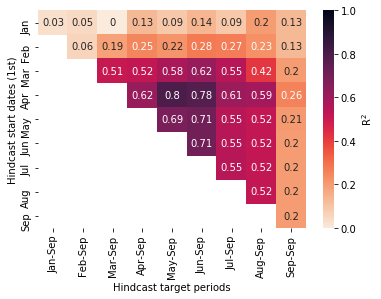

In [168]:
# Plot R2
cmap = sns.cm.rocket_r
ax = sns.heatmap(np.fliplr(rsquared_da), annot=True, cmap=cmap, cbar_kws={'label': 'R$^2$'}, vmin=0, vmax=1)
ax.set_xticklabels(np.flip(rsquared_da.target_period.values), rotation=90)
ax.set_yticklabels([datetime.datetime.strptime(str(x), "%m").strftime("%b") for x in rsquared_da.init_month.values], rotation=90)
ax.set(xlabel="Hindcast target periods", ylabel = "Hindcast start dates (1st)");

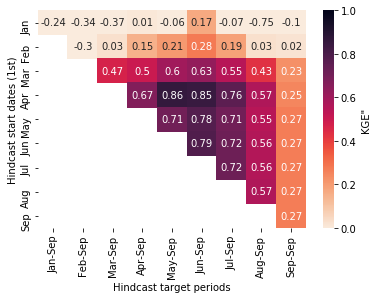

In [169]:
# Plot KGE"
cmap = sns.cm.rocket_r
ax = sns.heatmap(np.fliplr(KGE_da), annot=True, cmap=cmap, cbar_kws={'label': 'KGE"'}, vmin=0, vmax=1)
ax.set_xticklabels(np.flip(KGE_da.target_period.values), rotation=90)
ax.set_yticklabels([datetime.datetime.strptime(str(x), "%m").strftime("%b") for x in KGE_da.init_month.values], rotation=90)
ax.set(xlabel="Hindcast target periods", ylabel = "Hindcast start dates (1st)");

### With bootstrapping

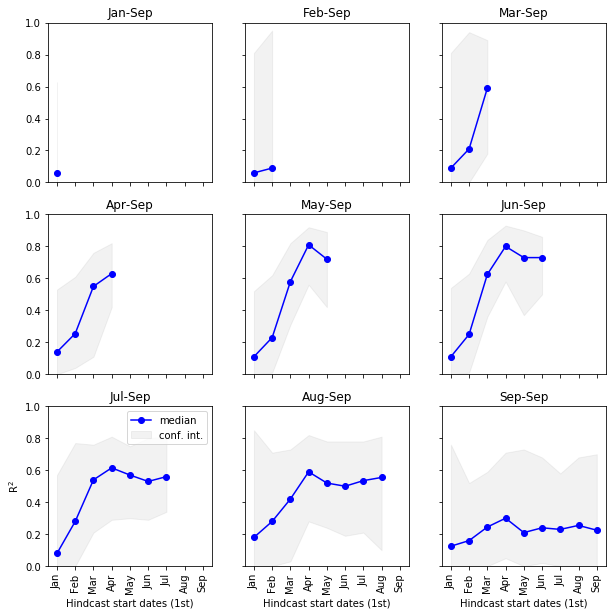

In [298]:
# Plot R2 with bootstrapping (flag_skill=0 to not plot a 0 value threshold line and flag_events=0 to plot this single metric)
metrics_bootstrap_plots(rsquared_bs_da, 0, 1, flag_skill=0, flag_events=0)

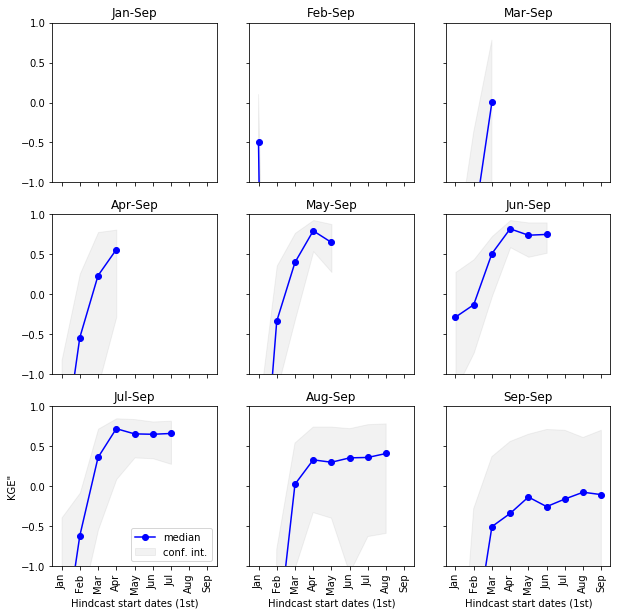

In [299]:
# Plot KGE" with bootstrapping (flag_skill=0 to not plot a 0 value threshold line and flag_events=0 to plot this single metric)
metrics_bootstrap_plots(KGE_bs_da, -1, 1, flag_skill=0, flag_events=0)

## Calculate & save probabilistic verification metrics

### Without bootstrapping

In [170]:
# Calculate probabilistic verification metrics without bootstrapping (flag=0)
crps_da, crpss_da, reli_da, roc_auc_da, roc_da = prob_metrics_calculation(Qobs=flow_volumes_testbasin, Qfc_ens=ens_fc_flow_volumes_testbasin, flag=0, niterations=None, perc_event_low=perc_event_low_default, perc_event_high=perc_event_high_default)

In [171]:
# Save into a single xarray DataFrame
prob_verif_metrics_testbasin = xr.merge([crps_da, crpss_da, reli_da, roc_auc_da, roc_da])

display(prob_verif_metrics_testbasin)

<xarray.Dataset>
Dimensions:            (bins: 11, event: 2, init_month: 9, rate: 2, target_period: 9)
Coordinates:
  * init_month         (init_month) int64 1 2 3 4 5 6 7 8 9
  * target_period      (target_period) <U7 'Sep-Sep' 'Aug-Sep' ... 'Jan-Sep'
  * event              (event) float64 0.33 0.66
  * rate               (rate) <U3 'FAR' 'HR'
  * bins               (bins) float64 0.0 0.1 0.2 0.3 0.4 ... 0.7 0.8 0.9 1.0
Data variables:
    CRPS               (init_month, target_period) float64 9.175e+06 ... nan
    CRPSS              (init_month, target_period) float64 0.06 0.01 ... nan nan
    Reliability_index  (init_month, target_period) float64 0.8 0.76 ... nan nan
    ROC_AUC            (init_month, target_period, event) float64 0.58 ... nan
    ROC                (init_month, target_period, rate, bins, event) float64 1.0 ... nan

### With bootstrapping

In [173]:
# Calculate probabilistic verification metrics with bootstrapping (flag=1)
crps_bs_da, crpss_bs_da, reli_bs_da, roc_auc_bs_da, roc_da = prob_metrics_calculation(Qobs=flow_volumes_testbasin, Qfc_ens=ens_fc_flow_volumes_testbasin, flag=1, niterations=niterations_default, perc_event_low=perc_event_low_default, perc_event_high=perc_event_high_default)

In [175]:
# Save into a single xarray DataFrame
prob_verif_metrics_bs_testbasin = xr.merge([crps_bs_da, crpss_bs_da, reli_bs_da, roc_auc_bs_da, roc_da])

display(prob_verif_metrics_bs_testbasin)

<xarray.Dataset>
Dimensions:            (bins: 11, event: 2, init_month: 9, iteration: 100, rate: 2, target_period: 9)
Coordinates:
  * init_month         (init_month) int64 1 2 3 4 5 6 7 8 9
  * target_period      (target_period) <U7 'Sep-Sep' 'Aug-Sep' ... 'Jan-Sep'
  * iteration          (iteration) int64 1 2 3 4 5 6 7 ... 94 95 96 97 98 99 100
  * event              (event) float64 0.33 0.66
  * rate               (rate) <U3 'FAR' 'HR'
  * bins               (bins) float64 0.0 0.1 0.2 0.3 0.4 ... 0.7 0.8 0.9 1.0
Data variables:
    CRPS               (init_month, target_period, iteration) float64 9.141e+06 ... nan
    CRPSS              (init_month, target_period, iteration) float64 0.05 ... nan
    Reliability_index  (init_month, target_period, iteration) float64 0.74 ... nan
    ROC_AUC            (init_month, target_period, iteration, event) float64 0.58 ... nan
    ROC                (init_month, target_period, iteration, rate, bins, event) float64 1.0 ... nan

## Plot probabilistic verification metrics

### Without bootstrapping

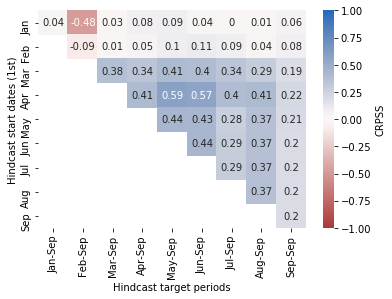

In [176]:
# Plot CRPSS
cmap = sns.cm.vlag_r
ax = sns.heatmap(np.fliplr(crpss_da), annot=True, cmap=cmap, cbar_kws={'label': 'CRPSS'}, center=0, vmin=-1, vmax=1)
ax.set_xticklabels(np.flip(crpss_da.target_period.values), rotation=90)
ax.set_yticklabels([datetime.datetime.strptime(str(x), "%m").strftime("%b") for x in crpss_da.init_month.values], rotation=90)
ax.set(xlabel="Hindcast target periods", ylabel = "Hindcast start dates (1st)");

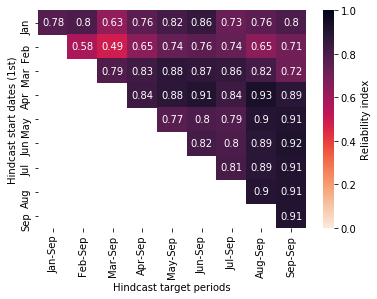

In [26]:
# Plot reliability index
cmap = sns.cm.rocket_r
ax = sns.heatmap(np.fliplr(reli_da), annot=True, cmap=cmap, cbar_kws={'label': 'Reliability index'}, vmin=0, vmax=1)
ax.set_xticklabels(np.flip(reli_da.target_period.values), rotation=90)
ax.set_yticklabels([datetime.datetime.strptime(str(x), "%m").strftime("%b") for x in reli_da.init_month.values], rotation=90)
ax.set(xlabel="Hindcast target periods", ylabel = "Hindcast start dates (1st)");

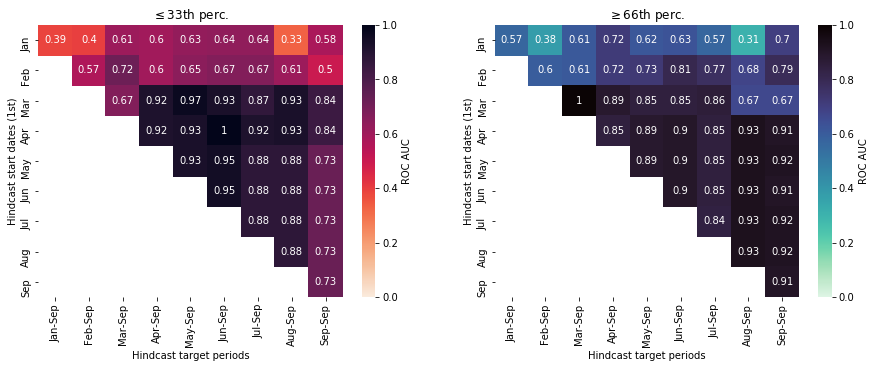

In [63]:
# Plot ROC area under the curve (ROC AUC)

# Initialize subplots
cmap_low = sns.cm.rocket_r
cmap_high = sns.cm.mako_r
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Low flows
sns.heatmap(np.fliplr(roc_auc_da.sel(event=perc_event_low_default)), annot=True, cmap=cmap_low, cbar_kws={'label': 'ROC AUC'}, vmin=0, vmax=1, ax=ax1)
ax1.set_xticklabels(np.flip(roc_auc_da.target_period.values), rotation=90)
ax1.set_yticklabels([datetime.datetime.strptime(str(x), "%m").strftime("%b") for x in roc_auc_da.init_month.values], rotation=90)
ax1.set(xlabel="Hindcast target periods", ylabel = "Hindcast start dates (1st)", title = "$\leq$"+str(int(perc_event_low_default*100))+"th perc.")

# High flows
sns.heatmap(np.fliplr(roc_auc_da.sel(event=perc_event_high_default)), annot=True, cmap=cmap_high, cbar_kws={'label': 'ROC AUC'}, vmin=0, vmax=1, ax=ax2)
ax2.set_xticklabels(np.flip(roc_auc_da.target_period.values), rotation=90)
ax2.set_yticklabels([datetime.datetime.strptime(str(x), "%m").strftime("%b") for x in roc_auc_da.init_month.values], rotation=90)
ax2.set(xlabel="Hindcast target periods", ylabel = "Hindcast start dates (1st)", title = "$\geq$"+str(int(perc_event_high_default*100))+"th perc.");

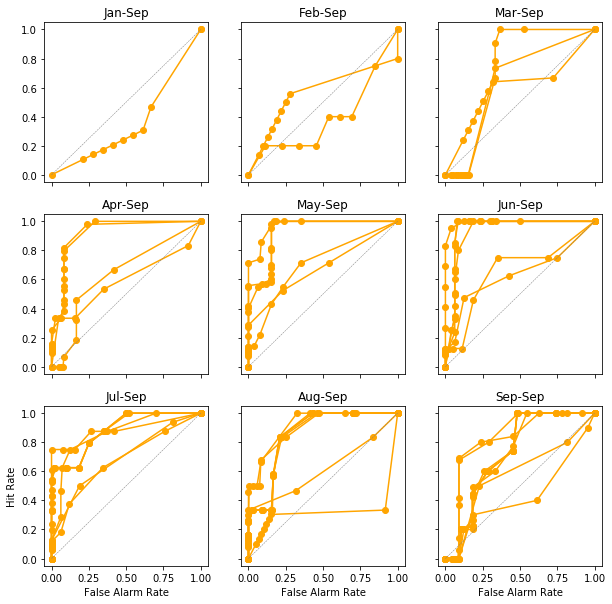

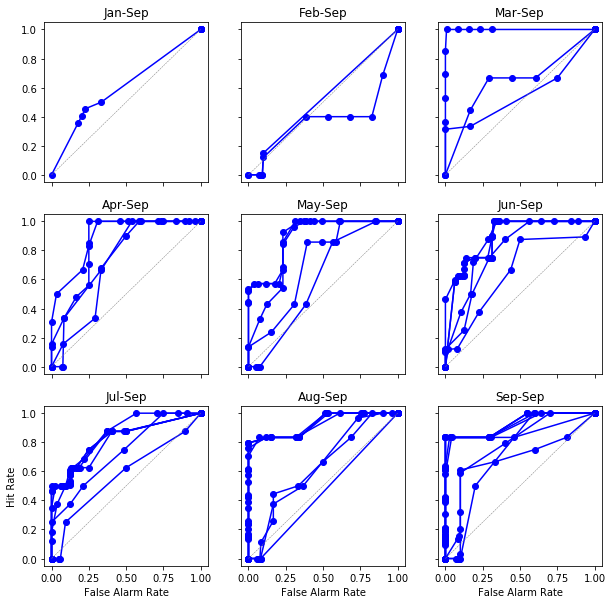

In [154]:
# Plot ROC curves

# Low flows
roc_plots(roc_da, percentile=perc_event_low_default)

# High flows
roc_plots(roc_da, percentile=perc_event_high_default)

### With bootstrapping

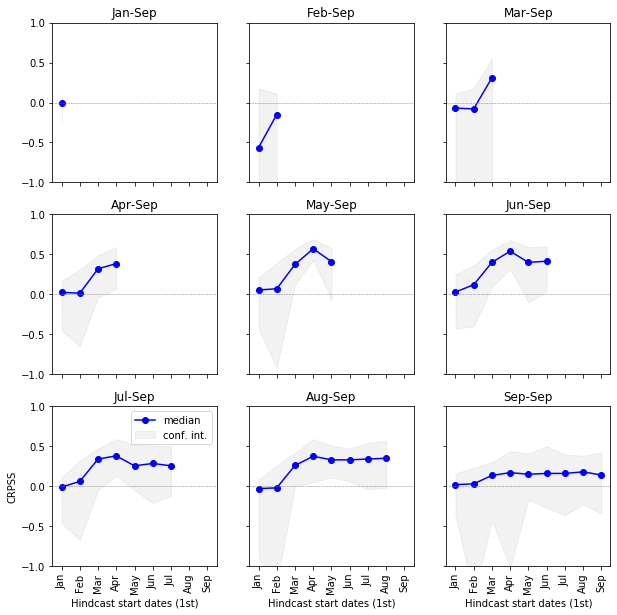

In [300]:
# Plot CRPSS with bootstrapping (flag_skill=1 to plot a 0 value threshold line and flag_events=0 to plot this single metric)
metrics_bootstrap_plots(crpss_bs_da, -1, 1, flag_skill=1, flag_events=0)

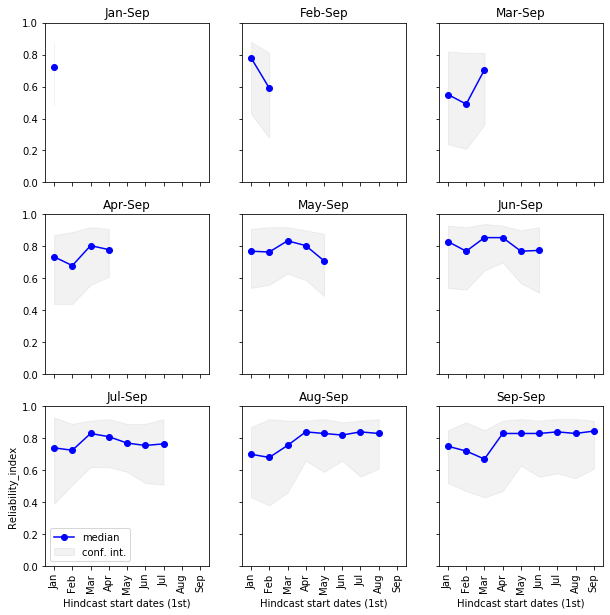

In [67]:
# Plot reliability index with bootstrapping (flag_skill=0 to not plot a 0 value threshold line and flag_events=0 to plot this single metric)
metrics_bootstrap_plots(reli_bs_da, 0, 1, flag_skill=0, flag_events=0)

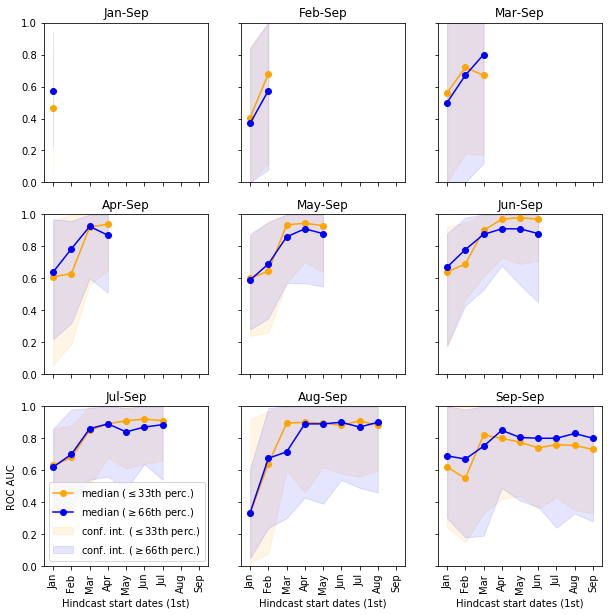

In [75]:
# Plot ROC AUC with bootstrapping (flag=0 to not plot a 0 value threshold line)
metrics_bootstrap_plots(roc_auc_bs_da, 0, 1, flag_skill=0, flag_events=1)

# Store hindcast verification results
This can then be read in this Notebook or called in any other Notebook of this workflow without having to re-run everything each single time. To read the stored data use: %store -r dataset_name

In [177]:
# Store data
%store det_verif_metrics_testbasin
%store det_verif_metrics_bs_testbasin
%store prob_verif_metrics_testbasin
%store prob_verif_metrics_bs_testbasin

Stored 'det_verif_metrics_testbasin' (Dataset)
Stored 'det_verif_metrics_bs_testbasin' (Dataset)
Stored 'prob_verif_metrics_testbasin' (Dataset)
Stored 'prob_verif_metrics_bs_testbasin' (Dataset)
